In [20]:
#Libraries and imports
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from abc_rule_miner import AGT, Node, calculate_dominant_behavior, select_highest_precedence_context
import random
from typing import List, Dict, Any
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [21]:
context_list = [
    'Interaction_Rate_Category', 'Course_ID', 'Resource_Type',
    'Learning_Efficiency_Category', 'Device_Type', 'TimeOfDay', 
    'DayOfWeek'
]

behavior_col = "Recommendation_Label"


In [22]:
def extract_rules(node, path=None, t=0.7, rules=None):
    """
    Recursively extract rules from the AGT tree.
    Includes intermediate nodes as valid rules.
    """
    if path is None:
        path = []
    if rules is None:
        rules = []

    # Extend the path for this node
    if node.value is not None:
        path = path + [f"{node.context}={node.value}"]

    # ✅ Add this node as a rule if it’s not too redundant or unconfident
    if node.behavior is not None and node.confidence >= t:
        rules.append((
            " AND ".join(path),
            node.behavior,
            node.confidence,
            node.node_type
        ))

    # Continue recursively for all children
    for child in node.children:
        extract_rules(child, path, t, rules)
    



    return rules


In [23]:
def print_tree(node, indent=0):
    prefix = "│   " * (indent - 1) + ("├── " if indent > 0 else "")
    print(f"{prefix}({node.context}={node.value}) → "
          f"Behavior={node.behavior}, Conf={node.confidence:.2f}, Type={node.node_type}")
    for child in node.children:
        print_tree(child, indent + 1)


In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import textwrap

def visualize_agt_tree(root, show_redundant=False, max_depth=20):
    """
    Visualize the Association Generation Tree (AGT) neatly as a hierarchical diagram.

    Args:
        root: Root node of the AGT
        show_redundant: Whether to include redundant nodes (default False)
        max_depth: Maximum depth (levels) of the tree to display (default = 20)
    """
    G = nx.DiGraph()

    # --- Recursive traversal to add nodes and edges ---
    def add_edges(node, parent=None, depth=0):
        if depth > max_depth:
            return  # stop at desired depth

        # Skip redundant nodes if not requested
        if node.node_type == "REDUNDANT" and not show_redundant:
            return

        # Build readable label
        label = f"{node.context}={node.value}\nB={node.behavior}\nC={node.confidence:.2f}"
        label = "\n".join(textwrap.wrap(label, width=22))
        color = '#f4cccc' if node.node_type == 'REDUNDANT' else '#a4c2f4'

        G.add_node(id(node), label=label, color=color)

        if parent:
            G.add_edge(id(parent), id(node))

        # Add child nodes recursively
        for child in node.children:
            add_edges(child, node, depth + 1)

    add_edges(root)

    # --- Compute hierarchical layout ---
    def hierarchy_pos(G, root=None, width=1., vert_gap=0.25, vert_loc=0, xcenter=0.5):
        """
        Compute hierarchical positions for nodes (top-down layout).
        """
        pos = {}
        children = list(G.successors(root))
        if len(children) != 0:
            dx = width / len(children)
            nextx = xcenter - width / 2 - dx / 2
            for child in children:
                nextx += dx
                pos.update(hierarchy_pos(G, child, width=dx, vert_gap=vert_gap,
                                         vert_loc=vert_loc - vert_gap, xcenter=nextx))
        pos[root] = (xcenter, vert_loc)
        return pos

    root_id = id(root)
    pos = hierarchy_pos(G, root=root_id)

    # --- Draw the graph ---
    colors = [G.nodes[n]['color'] for n in G.nodes()]
    labels = {n: G.nodes[n]['label'] for n in G.nodes()}

    # Adjust figure height dynamically based on number of nodes
    fig_height = min(max(10, len(G.nodes()) * 0.1), 50)

    plt.figure(figsize=(22, fig_height))
    nx.draw(G, pos, labels=labels, with_labels=True,
            node_color=colors, node_size=3500, font_size=7,
            font_weight="bold", edge_color="gray", arrows=False)

    plt.title(f"🌳 Association Generation Tree (Top {max_depth} Levels)", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [25]:
def print_redundant_nodes(node, depth=0):
    indent = "  " * depth
    if node.node_type == "REDUNDANT":
        print(f"{indent}🔁 Redundant Node: Context={node.context}, "
              f"Value={node.value}, Behavior={node.behavior}, "
              f"Confidence={node.confidence:.3f}")
    for child in node.children:
        print_redundant_nodes(child, depth + 1)




In [26]:
def extract_and_balance_rules(root, t=0.7):
    """Extract only 'Recommended' rules from AGT."""
    rules = extract_rules(root, t=t)
    all_rules_df = pd.DataFrame(rules, columns=["Conditions", "Behavior", "Confidence", "Type"])

    # Keep only normal-type rules
    all_rules_df = all_rules_df[all_rules_df["Type"] == "NORMAL"]

    # ✅ Keep only 'Recommended' rules
    recommended_rules = all_rules_df[all_rules_df["Behavior"] == "Recommended"].reset_index(drop=True)

    # ✅ Counts
    num_recommended_rules = len(recommended_rules)
    total_rules = len(all_rules_df)

    return recommended_rules, num_recommended_rules, total_rules

In [27]:
def predict_using_rules(df, rules_df, behavior_col="Recommendation_Label"):
    """Apply extracted rules to predict behavior."""
    preds = []
    covered = set()

    for i, row in df.iterrows():
        matched = False
        for _, rule in rules_df.iterrows():
            conditions = rule["Conditions"].split(" AND ") if rule["Conditions"] else []
            # Check if all conditions in rule match the row
            if all(str(row[c.split("=")[0]]) == c.split("=")[1] for c in conditions):
                preds.append(rule["Behavior"])
                covered.add(i)
                matched = True
                break
        # If no rule matched, predict as 'Not_Recommended'
        if not matched:
            preds.append("Not_Recommended")

    df["Predicted"] = preds
    coverage = len(covered) / len(df)
    return df, coverage


In [28]:
def evaluate_agt_rules(root, test_df, behavior_col="Recommendation_Label", t=0.7):
    """Full evaluation pipeline for AGT rule miner (Recommended-only rules)."""
    rules_df, num_rec_rules, total_rules = extract_and_balance_rules(root, t=t)

    # Remove duplicate conditions
    rules_df = rules_df.drop_duplicates(subset=["Conditions", "Behavior"], keep="first").reset_index(drop=True)

    # Predict using rules
    pred_df, coverage = predict_using_rules(test_df.copy(), rules_df, behavior_col)

    # Evaluation (compare predicted vs actual)
    y_true = pred_df[behavior_col]
    y_pred = pred_df["Predicted"]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label="Recommended", zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label="Recommended", zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label="Recommended", zero_division=0)

    # 🧾 Print evaluation summary
    print("\n📊 AGT Rule Miner (Recommended-only) Evaluation:")
    print(f"Total rules extracted:       {total_rules}")
    print(f"Recommended rules kept:      {num_rec_rules}")
    print(f"Coverage:                    {coverage:.3f}")
    print(f"Accuracy:                    {acc:.3f}")
    print(f"Precision:                   {prec:.3f}")
    print(f"Recall:                      {rec:.3f}")
    print(f"F1 Score:                    {f1:.3f}")

    # Return metrics for further analysis
    rules_df.to_csv("abc_rules.csv")
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "coverage": coverage,
        "total_rules": total_rules,
        "num_recommended_rules": num_rec_rules,
        #
    }

With balanced data

In [29]:
dataset = pd.read_csv('../Datasets/balanced_data.csv')

In [30]:
dataset.columns

Index(['Course_ID', 'Device_Type', 'Resource_Type', 'Recommendation_Label',
       'DayOfWeek', 'TimeOfDay', 'Prev_Courses_Category',
       'Learning_Efficiency_Category', 'Interaction_Rate_Category'],
      dtype='object')

In [31]:
dataset.head()

,Course_ID,Device_Type,Resource_Type,Recommendation_Label,DayOfWeek,TimeOfDay,Prev_Courses_Category,Learning_Efficiency_Category,Interaction_Rate_Category
0,C001,desktop,video,Recommended,Saturday,Afternoon,moderate,medium,medium
1,C005,mobile,video,Not_Recommended,Thursday,Morning,few,high,high
2,C005,desktop,quiz,Recommended,Tuesday,Morning,moderate,low,medium
3,C003,desktop,video,Recommended,Thursday,Night,moderate,medium,high
4,C003,desktop,video,Not_Recommended,Saturday,Night,few,high,high


In [32]:
dataset.drop(columns=[ 'Prev_Courses_Category'], inplace=True)

In [33]:
#train data = 3456*0.7 = 2419
#test data = 3456*0.3 = 1037

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=42)


In [34]:
DS_balanced = train_dataset[context_list + [behavior_col]].to_dict(orient='records')

In [35]:
len(DS_balanced)

2419

In [36]:
root = AGT(DS_balanced,context_list,behavior_col,0.6)

C:\Users\joyee\AppData\Local\Temp\ipykernel_17344\2409926286.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


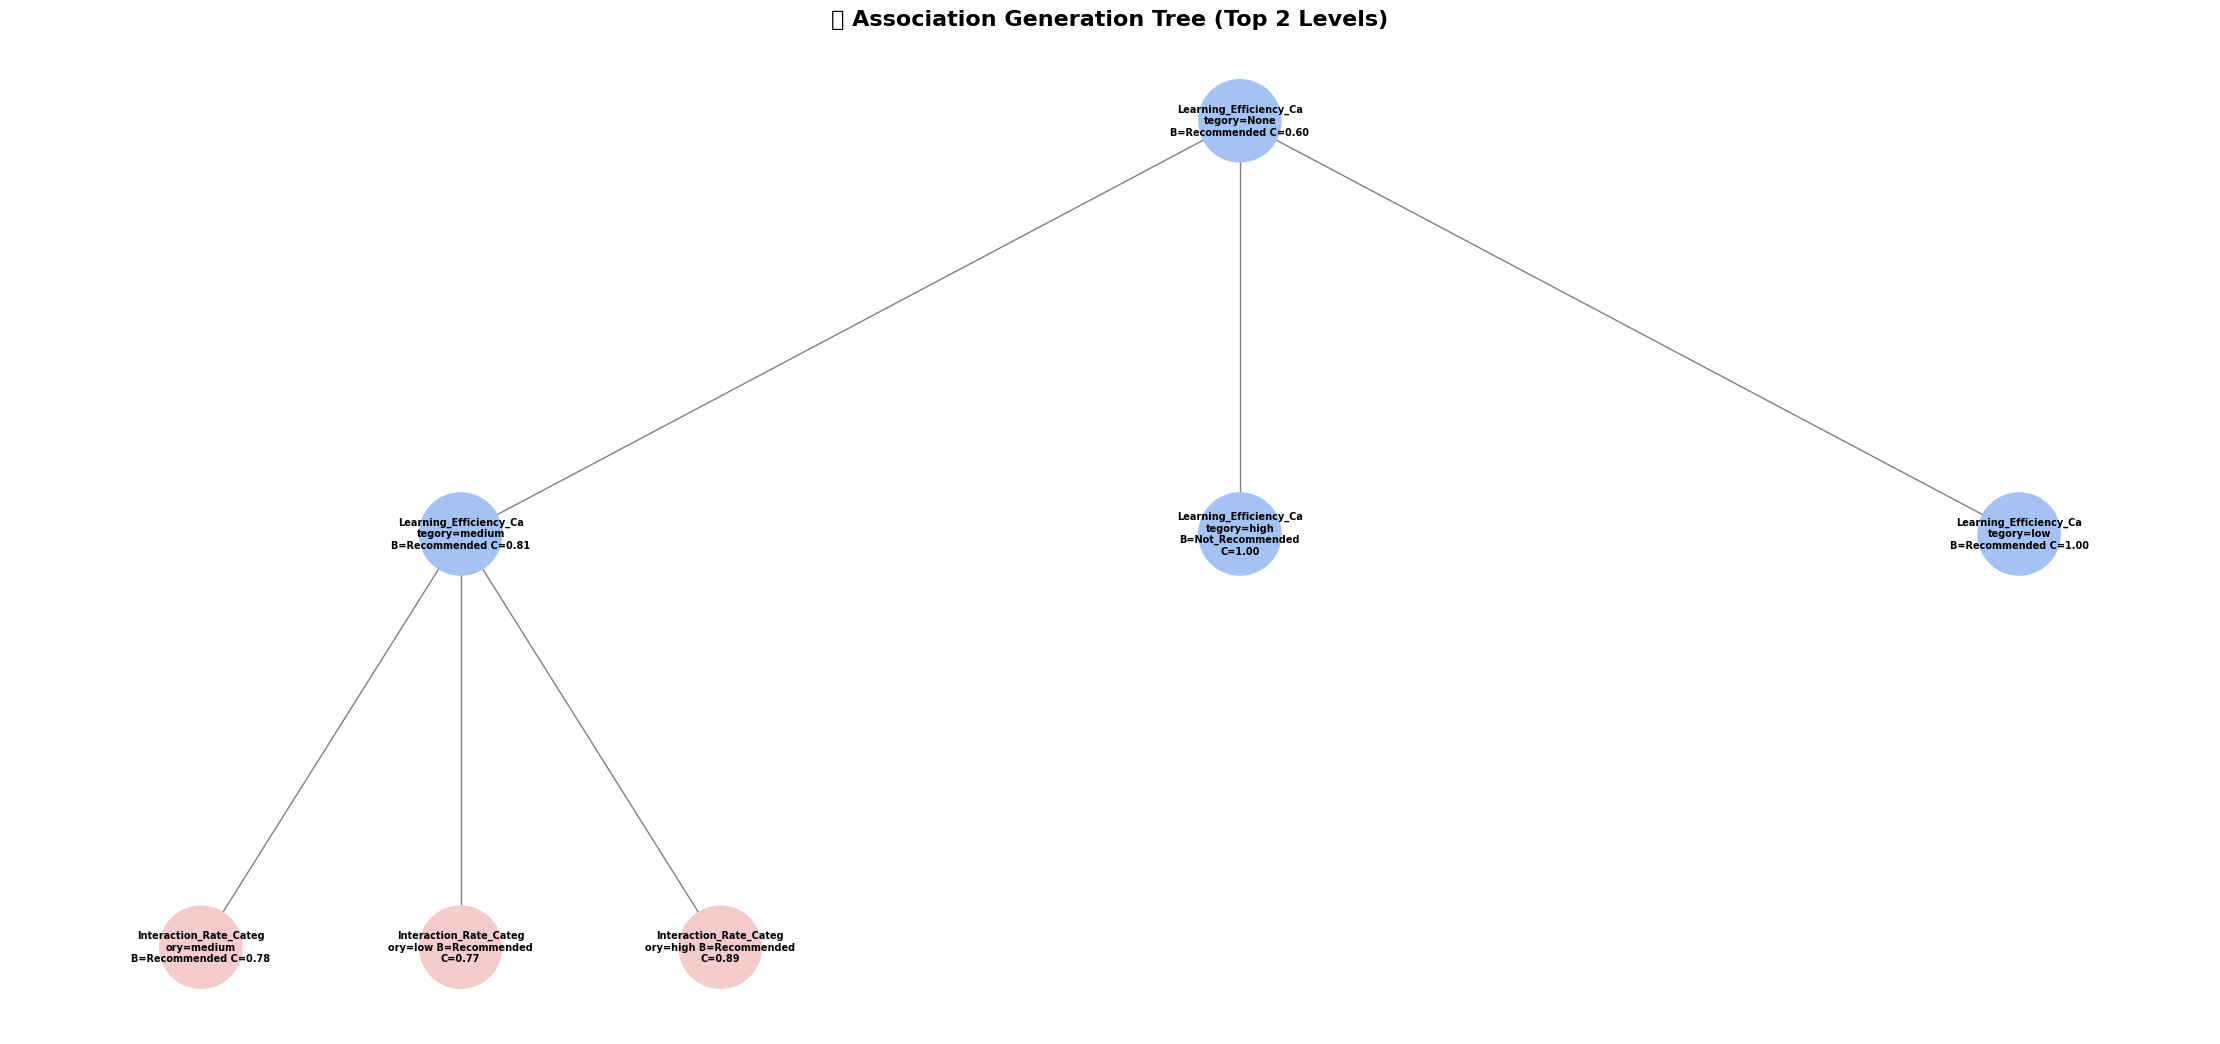

In [38]:
visualize_agt_tree(root,show_redundant=True,max_depth=2)

In [2]:
 evaluate_agt_rules(root,test_dataset,behavior_col,0.6)

NameError: name 'evaluate_agt_rules' is not defined

In [4]:


# Store metrics for each t
results = []

t_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in t_values:
    print(f"\n\nEvaluating for threshold t = {i}")
    
    root = AGT(DS_balanced, context_list, behavior_col, t=i)
    
    # Assuming evaluate_agt_rules returns a dict of metrics
    metrics = evaluate_agt_rules(root, test_dataset, behavior_col="Recommendation_Label", t=i)
    
    # Store metrics
    results.append({
        "t": i,
        "Accuracy": round(metrics["accuracy"],3),
        "Precision": round(metrics["precision"],3),
        "Recall": round(metrics["recall"],3),
        "F1": round(metrics["f1"],3),
        
        "num_rules": metrics['num_recommended_rules']
    })

# Convert results to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)

# Plot metrics
plt.figure(figsize=(10,6))
plt.plot(results_df["t"], results_df["Accuracy"], marker='o', label="Accuracy")
plt.plot(results_df["t"], results_df["Precision"], marker='s', label="Precision")
plt.plot(results_df["t"], results_df["Recall"], marker='^', label="Recall")
plt.plot(results_df["t"], results_df["F1"], marker='D', label="F1 Score")


plt.xlabel("Threshold (t)")
plt.ylabel("Score")
plt.title("AGT Performance Metrics vs Confidence Threshold (t)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Show numeric results
display(results_df)




Evaluating for threshold t = 0.1


NameError: name 'AGT' is not defined

In [5]:
results_df[['t','num_rules']]

NameError: name 'results_df' is not defined

In [6]:
apriori_rules = pd.read_csv("Apriori_rules.csv")

NameError: name 'pd' is not defined

In [7]:
results_df

NameError: name 'results_df' is not defined

In [ ]:
apriori_rules

,Unnamed: 0,Confidence_Threshold,rules_recom
0,0,0.1,108
1,1,0.2,108
2,2,0.3,108
3,3,0.4,108
4,4,0.5,107
5,5,0.6,70
6,6,0.7,46
7,7,0.8,31
8,8,0.9,20


In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))

# Plot Apriori
plt.plot(apriori_rules["Confidence_Threshold"], apriori_rules["rules_recom"],
         marker="o", color="blue", label="Apriori - Recommended Rules", linewidth=2)

# Plot ABC / AGT
plt.plot(results_df["t"], results_df["num_rules"],
         marker="s", color="orange", label="ABC Rule Miner (AGT) - Rules", linewidth=2)

# Styling
plt.title("Number of Rules vs Confidence Threshold", fontsize=14)
plt.xlabel("Confidence Threshold (t)", fontsize=12)
plt.ylabel("Number of Rules Generated", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=11)
plt.show()


NameError: name 'apriori_rules' is not defined

<Figure size 800x500 with 0 Axes>

In [ ]:
results_df

,t,Accuracy,Precision,Recall,F1,Coverage
0,0.1,0.631,0.631,1.000,0.774,1.000
1,0.2,0.631,0.631,1.000,0.774,1.000
2,0.3,0.631,0.631,1.000,0.774,1.000
3,0.4,0.631,0.631,1.000,0.774,1.000
4,0.5,0.631,0.631,1.000,0.774,1.000
5,0.6,0.943,0.917,1.000,0.957,0.688
6,0.7,0.943,0.917,1.000,0.957,0.688
7,0.8,0.943,0.917,1.000,0.957,0.688
8,0.9,0.887,0.930,0.888,0.909,0.603
